# Multi-Class Segmentation Results Visualization
This notebook visualizes the multi-class segmentation masks generated by the model and compares them with ground truth.

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pathlib import Path
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm

# Set matplotlib style
plt.style.use('default')
%matplotlib inline

## Configuration

In [15]:
# Paths
IMAGE_DIR = "/data/tl28853/eye/NR206/test_512"
MASK_DIR = "/data/tl28853/eye/NR206/pred_multiclass"
GT_DIR = "/data/tl28853/eye/NR206/masks"

# Class names and colors (9 classes)
CLASS_NAMES = [
    'Background',
    'Sclera',
    'Iris',
    'Pupil',
    'Upper Eyelid',
    'Lower Eyelid',
    'Upper Eyelash',
    'Lower Eyelash',
    'Caruncle'
]

# Define colors for each class (BGR format for cv2, RGB for matplotlib)
CLASS_COLORS = np.array([
    [0, 0, 0],       # 0: Background - Black
    [255, 255, 255], # 1: Sclera - White
    [0, 255, 0],     # 2: Iris - Green
    [255, 0, 0],     # 3: Pupil - Red
    [0, 255, 255],   # 4: Upper Eyelid - Cyan
    [255, 255, 0],   # 5: Lower Eyelid - Yellow
    [255, 0, 255],   # 6: Upper Eyelash - Magenta
    [128, 0, 128],   # 7: Lower Eyelash - Purple
    [255, 128, 0]    # 8: Caruncle - Orange
], dtype=np.uint8)

# Get all images
image_path = Path(IMAGE_DIR)
mask_path = Path(MASK_DIR)
gt_path = Path(GT_DIR)

image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
image_files = sorted([f for f in image_path.iterdir() if f.suffix.lower() in image_extensions])

print(f"Found {len(image_files)} images")
print(f"Number of classes: {len(CLASS_NAMES)}")

Found 40 images
Number of classes: 9


## Visualization Functions

In [16]:
def load_image_and_mask(image_file):
    """Load image and corresponding prediction mask"""
    img_path = image_path / image_file.name
    msk_path = mask_path / image_file.name
    
    # Load image
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load mask (class indices)
    mask = cv2.imread(str(msk_path), cv2.IMREAD_GRAYSCALE)
    
    return image, mask


def load_image_mask_and_gt(image_file):
    """Load image, prediction mask, and ground truth"""
    img_path = image_path / image_file.name
    msk_path = mask_path / image_file.name
    gt_msk_path = gt_path / image_file.name
    
    # Load image
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load prediction mask
    pred_mask = cv2.imread(str(msk_path), cv2.IMREAD_GRAYSCALE)
    
    # Load ground truth mask
    gt_mask = cv2.imread(str(gt_msk_path), cv2.IMREAD_GRAYSCALE)
    
    return image, pred_mask, gt_mask


def mask_to_colored(mask):
    """Convert class indices mask to colored RGB mask"""
    h, w = mask.shape
    colored_mask = np.zeros((h, w, 3), dtype=np.uint8)
    
    for class_idx in range(len(CLASS_COLORS)):
        colored_mask[mask == class_idx] = CLASS_COLORS[class_idx]
    
    return colored_mask


def create_difference_mask(pred_mask, gt_mask):
    """Create a difference mask highlighting correct and incorrect predictions"""
    h, w = pred_mask.shape
    diff_mask = np.zeros((h, w, 3), dtype=np.uint8)
    
    # Green: correct predictions
    correct = pred_mask == gt_mask
    diff_mask[correct] = [0, 255, 0]
    
    # Red: incorrect predictions
    incorrect = pred_mask != gt_mask
    diff_mask[incorrect] = [255, 0, 0]
    
    return diff_mask


def create_legend():
    """Create legend patches for classes"""
    legend_elements = [
        Patch(facecolor=CLASS_COLORS[i]/255.0, label=CLASS_NAMES[i])
        for i in range(len(CLASS_NAMES))
    ]
    return legend_elements


def visualize_single(image, mask, title=""):
    """Visualize single image with multi-class mask"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image', fontsize=12)
    axes[0].axis('off')
    
    # Colored mask
    colored_mask = mask_to_colored(mask)
    axes[1].imshow(colored_mask)
    axes[1].set_title('Predicted Segmentation', fontsize=12)
    axes[1].axis('off')
    
    # Overlay
    overlay = cv2.addWeighted(image, 0.6, colored_mask, 0.4, 0)
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay', fontsize=12)
    axes[2].axis('off')
    
    if title:
        fig.suptitle(title, fontsize=14, fontweight='bold')
    
    # Add legend
    legend_elements = create_legend()
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.0, 0.5), 
               fontsize=10, frameon=True)
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.show()


def visualize_comparison(image, pred_mask, gt_mask, title=""):
    """Visualize image with prediction and ground truth comparison"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Original, Ground Truth, Prediction
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Image', fontsize=12)
    axes[0, 0].axis('off')
    
    gt_colored = mask_to_colored(gt_mask)
    axes[0, 1].imshow(gt_colored)
    axes[0, 1].set_title('Ground Truth', fontsize=12)
    axes[0, 1].axis('off')
    
    pred_colored = mask_to_colored(pred_mask)
    axes[0, 2].imshow(pred_colored)
    axes[0, 2].set_title('Prediction', fontsize=12)
    axes[0, 2].axis('off')
    
    # Row 2: GT Overlay, Pred Overlay, Difference
    gt_overlay = cv2.addWeighted(image, 0.6, gt_colored, 0.4, 0)
    axes[1, 0].imshow(gt_overlay)
    axes[1, 0].set_title('GT Overlay', fontsize=12)
    axes[1, 0].axis('off')
    
    pred_overlay = cv2.addWeighted(image, 0.6, pred_colored, 0.4, 0)
    axes[1, 1].imshow(pred_overlay)
    axes[1, 1].set_title('Pred Overlay', fontsize=12)
    axes[1, 1].axis('off')
    
    diff_mask = create_difference_mask(pred_mask, gt_mask)
    axes[1, 2].imshow(diff_mask)
    axes[1, 2].set_title('Difference (Green=Correct, Red=Wrong)', fontsize=12)
    axes[1, 2].axis('off')
    
    # Calculate accuracy
    accuracy = np.mean(pred_mask == gt_mask) * 100
    
    if title:
        fig.suptitle(f"{title}\nPixel Accuracy: {accuracy:.2f}%", fontsize=14, fontweight='bold')
    
    # Add legend
    legend_elements = create_legend()
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.0, 0.5), 
               fontsize=10, frameon=True)
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.show()


def visualize_grid(image_files, n_samples=6):
    """Visualize multiple images in a grid"""
    fig, axes = plt.subplots(n_samples, 3, figsize=(18, 6*n_samples))
    
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, img_file in enumerate(image_files[:n_samples]):
        image, mask = load_image_and_mask(img_file)
        colored_mask = mask_to_colored(mask)
        
        # Original image
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f'{img_file.name} - Original', fontsize=10)
        axes[i, 0].axis('off')
        
        # Colored mask
        axes[i, 1].imshow(colored_mask)
        axes[i, 1].set_title('Segmentation', fontsize=10)
        axes[i, 1].axis('off')
        
        # Overlay
        overlay = cv2.addWeighted(image, 0.6, colored_mask, 0.4, 0)
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title('Overlay', fontsize=10)
        axes[i, 2].axis('off')
    
    # Add legend
    legend_elements = create_legend()
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.0, 0.5), 
               fontsize=10, frameon=True)
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.show()


def visualize_comparison_grid(image_files, n_samples=4):
    """Visualize multiple images with GT comparison in a grid"""
    fig, axes = plt.subplots(n_samples, 4, figsize=(20, 5*n_samples))
    
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, img_file in enumerate(image_files[:n_samples]):
        image, pred_mask, gt_mask = load_image_mask_and_gt(img_file)
        
        # Original image
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f'{img_file.name}', fontsize=10)
        axes[i, 0].axis('off')
        
        # Ground truth
        gt_colored = mask_to_colored(gt_mask)
        axes[i, 1].imshow(gt_colored)
        axes[i, 1].set_title('Ground Truth', fontsize=10)
        axes[i, 1].axis('off')
        
        # Prediction
        pred_colored = mask_to_colored(pred_mask)
        axes[i, 2].imshow(pred_colored)
        axes[i, 2].set_title('Prediction', fontsize=10)
        axes[i, 2].axis('off')
        
        # Difference
        diff_mask = create_difference_mask(pred_mask, gt_mask)
        accuracy = np.mean(pred_mask == gt_mask) * 100
        axes[i, 3].imshow(diff_mask)
        axes[i, 3].set_title(f'Diff (Acc: {accuracy:.1f}%)', fontsize=10)
        axes[i, 3].axis('off')
    
    # Add legend
    legend_elements = create_legend()
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.0, 0.5), 
               fontsize=10, frameon=True)
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    plt.show()

## Display Single Random Sample with GT Comparison

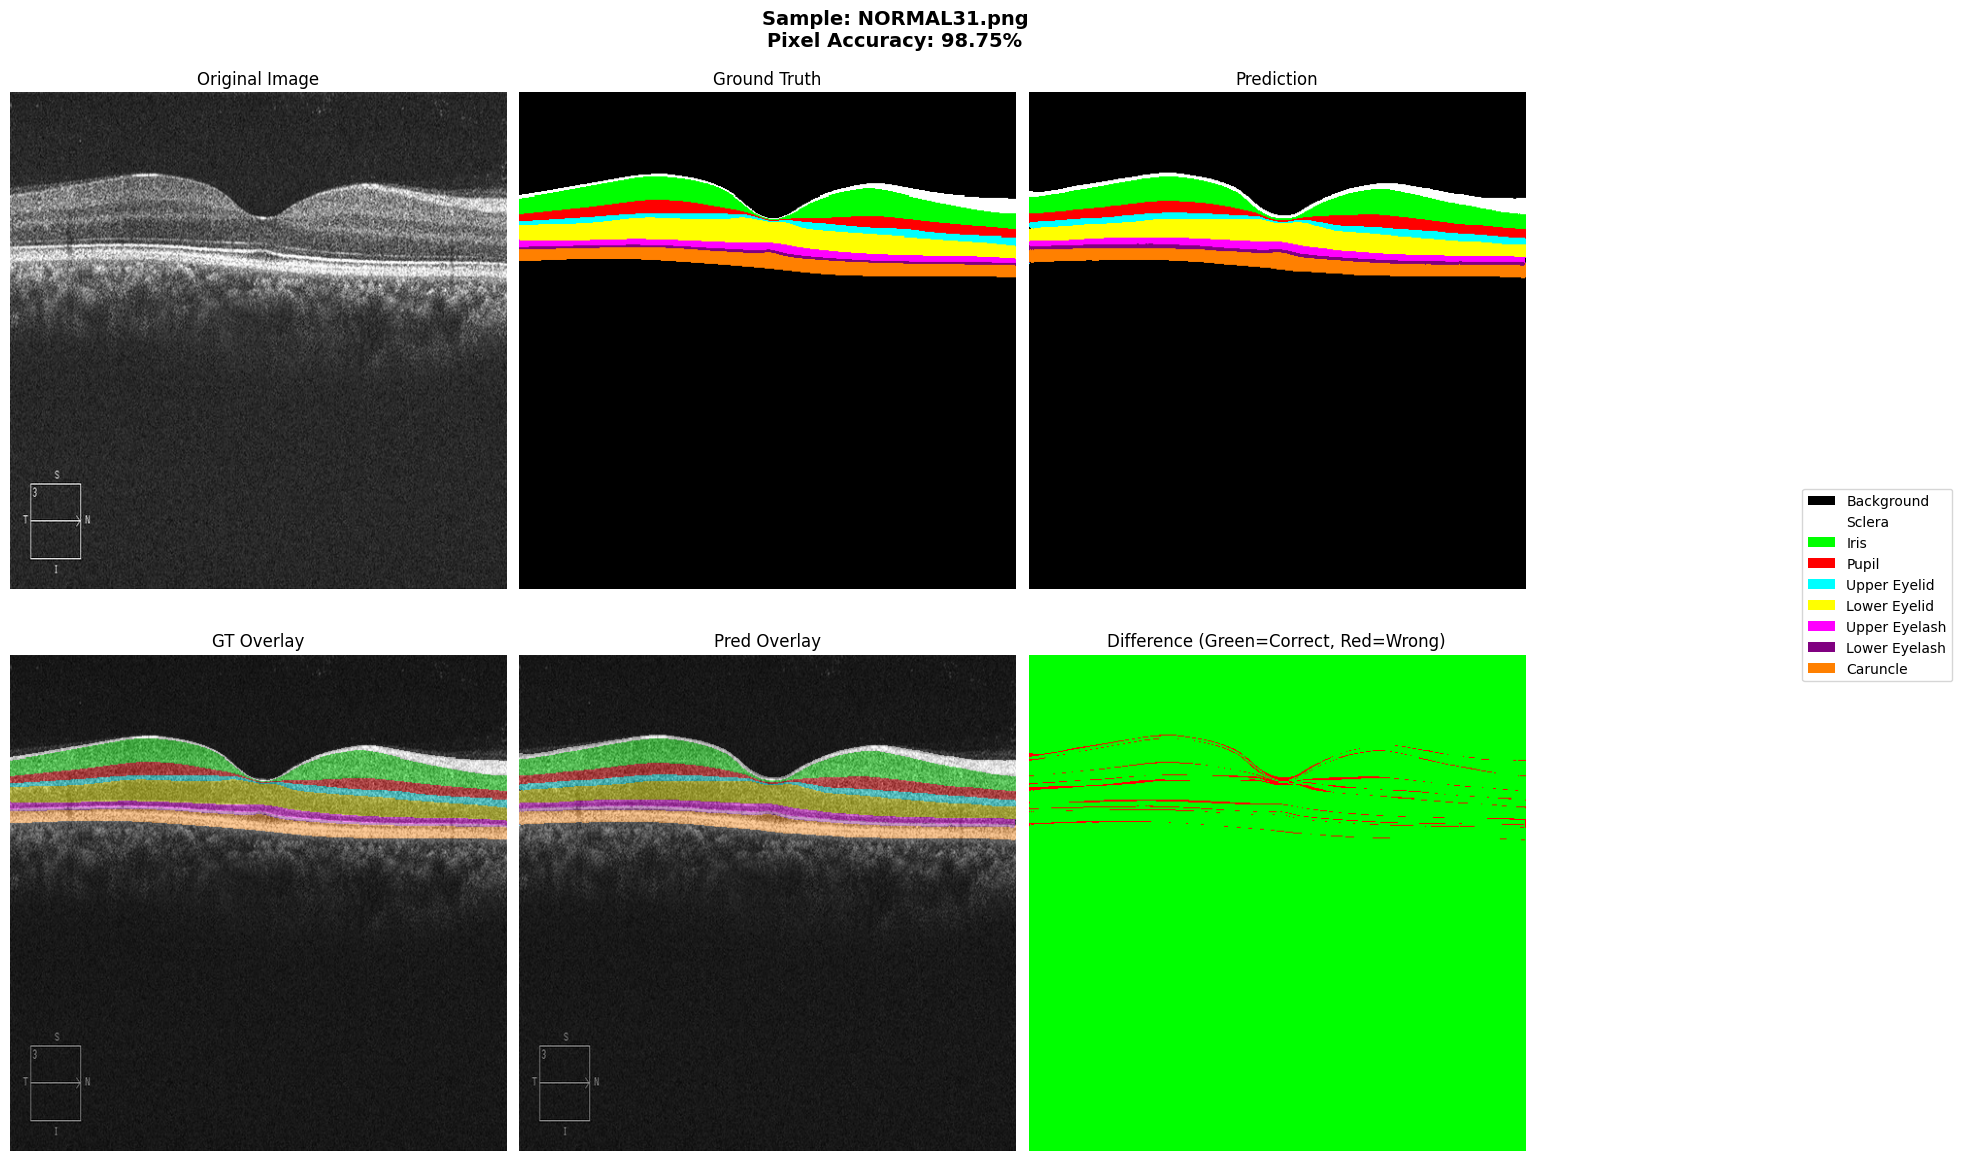

In [17]:
# Select a random image
random_image = random.choice(image_files)
image, pred_mask, gt_mask = load_image_mask_and_gt(random_image)

visualize_comparison(image, pred_mask, gt_mask, title=f"Sample: {random_image.name}")

## Display Specific Image by Index with GT Comparison

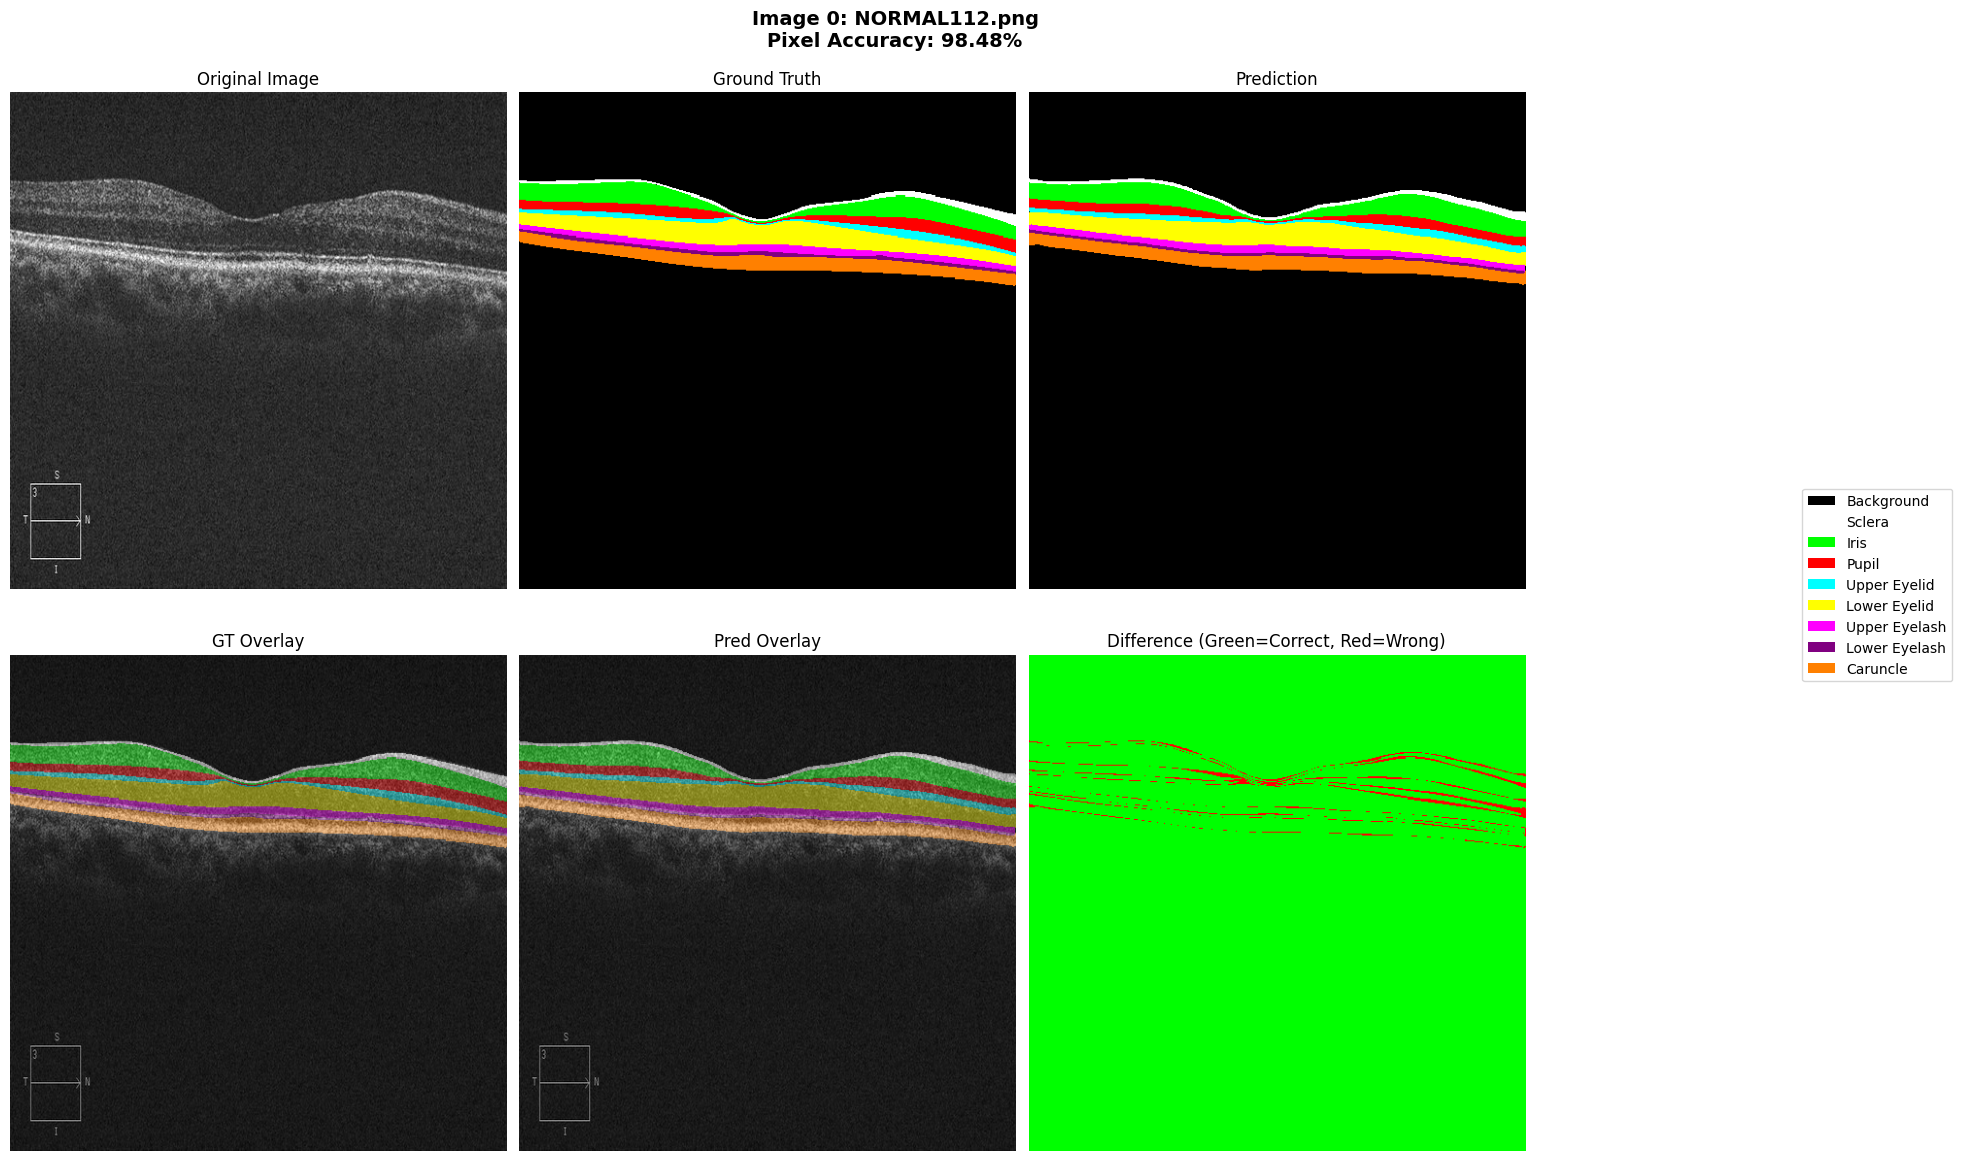

In [18]:
# Change index to view different images (0 to len(image_files)-1)
index = 0

if index < len(image_files):
    image, pred_mask, gt_mask = load_image_mask_and_gt(image_files[index])
    visualize_comparison(image, pred_mask, gt_mask, title=f"Image {index}: {image_files[index].name}")
else:
    print(f"Index {index} out of range. Max index: {len(image_files)-1}")

## Display Multiple Samples with GT Comparison

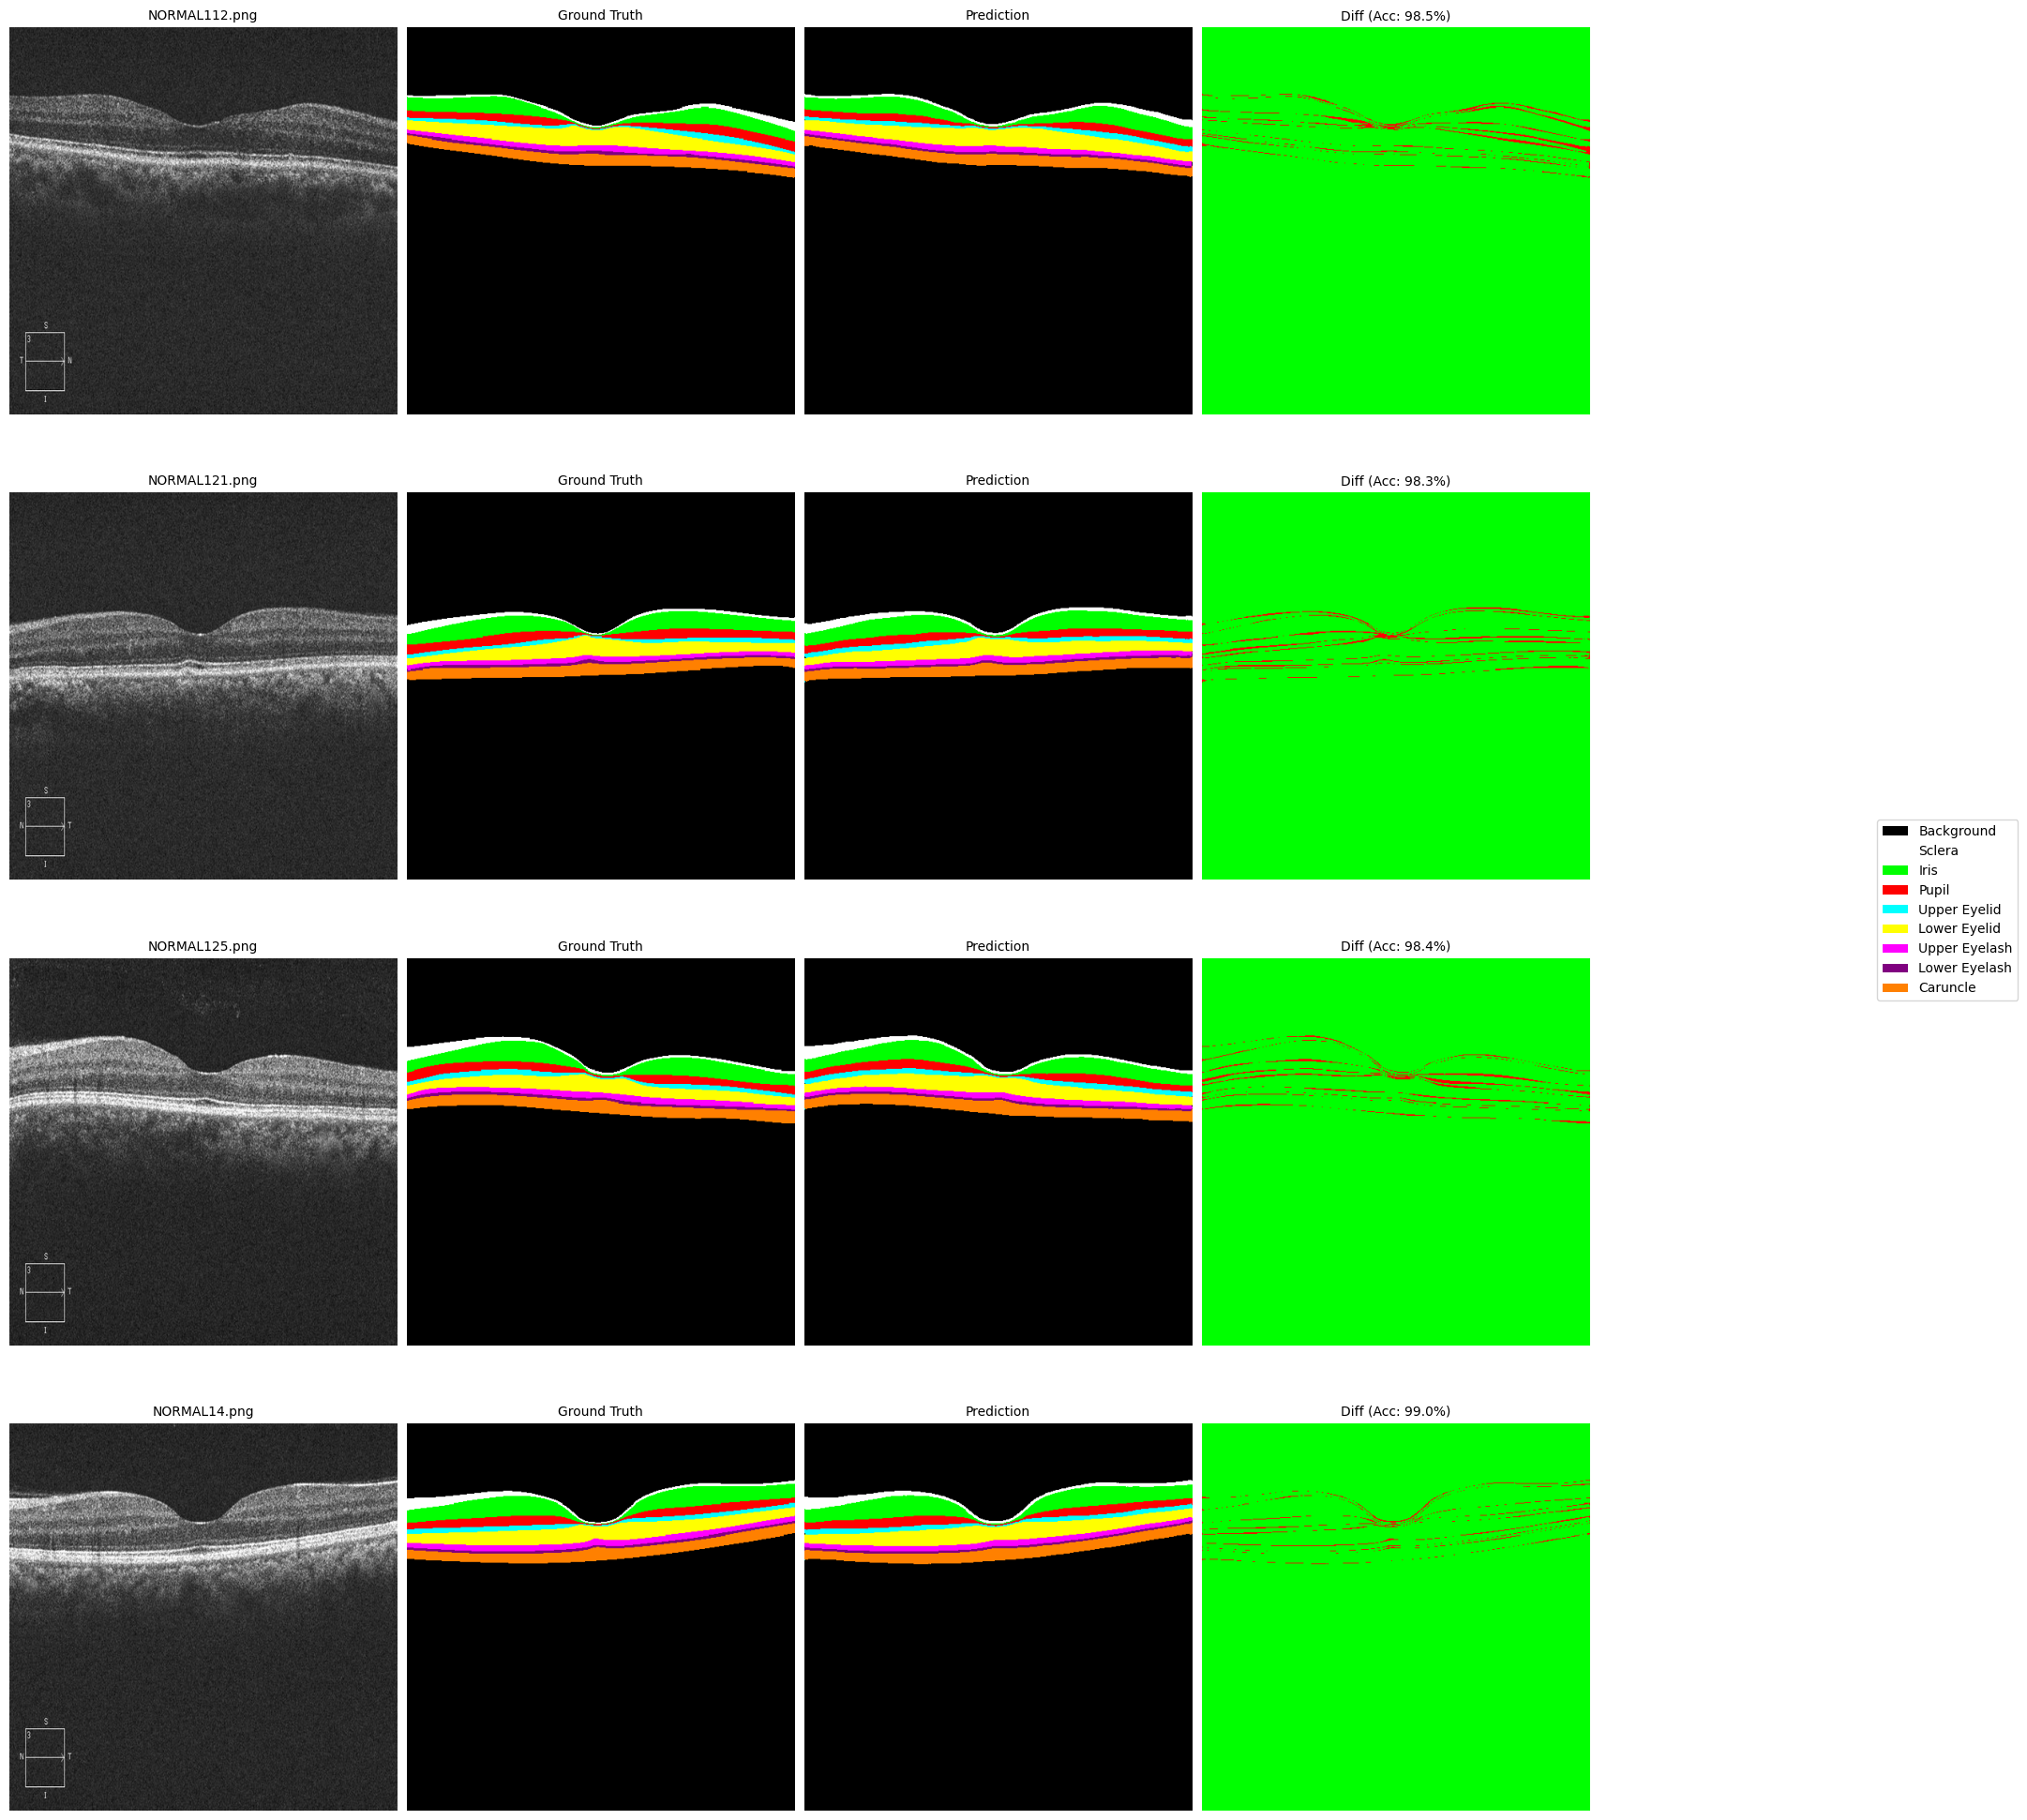

In [19]:
# Display first 4 images with GT comparison
visualize_comparison_grid(image_files, n_samples=min(4, len(image_files)))

## Display Random Samples with GT Comparison

In [ ]:
# Display 4 random samples with GT comparison
random_samples = random.sample(image_files, min(4, len(image_files)))
visualize_comparison_grid(random_samples, n_samples=len(random_samples))

## Overall Evaluation Metrics

In [ ]:
# Calculate overall metrics
all_pred = []
all_gt = []
pixel_accuracies = []

print("Computing metrics...")
for img_file in tqdm(image_files, desc="Processing images"):
    msk_path = mask_path / img_file.name
    gt_msk_path = gt_path / img_file.name
    
    pred_mask = cv2.imread(str(msk_path), cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(str(gt_msk_path), cv2.IMREAD_GRAYSCALE)
    
    all_pred.extend(pred_mask.flatten())
    all_gt.extend(gt_mask.flatten())
    
    # Pixel accuracy for this image
    pixel_acc = np.mean(pred_mask == gt_mask) * 100
    pixel_accuracies.append(pixel_acc)

# Convert to numpy arrays
all_pred = np.array(all_pred)
all_gt = np.array(all_gt)

# Overall pixel accuracy
overall_accuracy = np.mean(all_pred == all_gt) * 100

print(f"\nOverall Pixel Accuracy: {overall_accuracy:.2f}%")
print(f"Mean Image Accuracy: {np.mean(pixel_accuracies):.2f}% ± {np.std(pixel_accuracies):.2f}%")
print(f"Min Image Accuracy: {np.min(pixel_accuracies):.2f}%")
print(f"Max Image Accuracy: {np.max(pixel_accuracies):.2f}%")

# Plot accuracy distribution
plt.figure(figsize=(10, 6))
plt.hist(pixel_accuracies, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(pixel_accuracies), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(pixel_accuracies):.2f}%')
plt.xlabel('Pixel Accuracy (%)', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Pixel Accuracy Across Images', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Confusion Matrix

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(all_gt, all_pred, labels=range(len(CLASS_NAMES)))

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted Class', fontsize=12)
ax1.set_ylabel('True Class', fontsize=12)
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax1.get_yticklabels(), rotation=0)

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax2,
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cbar_kws={'label': 'Percentage'})
ax2.set_xlabel('Predicted Class', fontsize=12)
ax2.set_ylabel('True Class', fontsize=12)
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax2.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Print per-class accuracy
print("\nPer-Class Accuracy:")
print("-" * 60)
for i, class_name in enumerate(CLASS_NAMES):
    class_accuracy = cm_normalized[i, i] * 100
    print(f"{i}. {class_name:20s}: {class_accuracy:6.2f}%")

## Per-Class IoU (Intersection over Union)

In [ ]:
# Calculate IoU for each class
ious = []

for i in range(len(CLASS_NAMES)):
    # True Positives
    tp = cm[i, i]
    # False Positives + False Negatives
    fp_fn = cm[i, :].sum() + cm[:, i].sum() - tp
    
    if fp_fn > 0:
        iou = tp / fp_fn
    else:
        iou = 0.0
    
    ious.append(iou * 100)

# Mean IoU
mean_iou = np.mean(ious)

# Plot IoU
fig, ax = plt.subplots(figsize=(12, 6))
colors = CLASS_COLORS / 255.0
x_pos = np.arange(len(CLASS_NAMES))
bars = ax.bar(x_pos, ious, color=colors)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('IoU (%)', fontsize=12)
ax.set_title(f'Per-Class IoU (Mean IoU: {mean_iou:.2f}%)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(mean_iou, color='r', linestyle='--', linewidth=2, label=f'Mean IoU: {mean_iou:.2f}%')
ax.legend()

# Add value labels
for bar, iou in zip(bars, ious):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{iou:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print IoU values
print("\nPer-Class IoU:")
print("-" * 60)
for i, (name, iou) in enumerate(zip(CLASS_NAMES, ious)):
    print(f"{i}. {name:20s}: {iou:6.2f}%")
print("-" * 60)
print(f"Mean IoU: {mean_iou:.2f}%")

## Class Distribution Comparison (GT vs Prediction)

In [ ]:
# Calculate class distribution for both GT and predictions
gt_class_counts = np.zeros(len(CLASS_NAMES), dtype=np.int64)
pred_class_counts = np.zeros(len(CLASS_NAMES), dtype=np.int64)

for img_file in image_files:
    msk_path = mask_path / img_file.name
    gt_msk_path = gt_path / img_file.name
    
    pred_mask = cv2.imread(str(msk_path), cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(str(gt_msk_path), cv2.IMREAD_GRAYSCALE)
    
    for class_idx in range(len(CLASS_NAMES)):
        gt_class_counts[class_idx] += np.sum(gt_mask == class_idx)
        pred_class_counts[class_idx] += np.sum(pred_mask == class_idx)

# Calculate percentages
total_pixels = np.sum(gt_class_counts)
gt_percentages = (gt_class_counts / total_pixels) * 100
pred_percentages = (pred_class_counts / total_pixels) * 100

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 7))

x_pos = np.arange(len(CLASS_NAMES))
width = 0.35

bars1 = ax.bar(x_pos - width/2, gt_percentages, width, label='Ground Truth', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, pred_percentages, width, label='Prediction', alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Class Distribution: Ground Truth vs Prediction', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print comparison
print("\nClass Distribution Comparison:")
print("-" * 80)
print(f"{'Class':<20} {'GT %':>10} {'Pred %':>10} {'Difference':>12}")
print("-" * 80)
for i, name in enumerate(CLASS_NAMES):
    diff = pred_percentages[i] - gt_percentages[i]
    print(f"{name:<20} {gt_percentages[i]:>9.2f}% {pred_percentages[i]:>9.2f}% {diff:>+11.2f}%")

## Interactive Viewer (Browse Images with GT Comparison)

In [ ]:
# Simple interactive viewer - run this cell and change current_idx to browse
current_idx = 0

def show_image(idx):
    if 0 <= idx < len(image_files):
        image, pred_mask, gt_mask = load_image_mask_and_gt(image_files[idx])
        
        # Print statistics for this image
        print(f"\n{'='*60}")
        print(f"Image: {image_files[idx].name}")
        print(f"{'='*60}")
        
        # Overall accuracy
        accuracy = np.mean(pred_mask == gt_mask) * 100
        print(f"Pixel Accuracy: {accuracy:.2f}%")
        
        # Per-class statistics
        unique_gt = np.unique(gt_mask)
        unique_pred = np.unique(pred_mask)
        
        print(f"\n{'Class':<20} {'GT Pixels':>12} {'Pred Pixels':>12} {'Accuracy':>10}")
        print("-" * 60)
        
        all_classes = sorted(set(unique_gt) | set(unique_pred))
        for class_idx in all_classes:
            gt_pixels = np.sum(gt_mask == class_idx)
            pred_pixels = np.sum(pred_mask == class_idx)
            
            # Class-specific accuracy
            if gt_pixels > 0:
                class_mask = gt_mask == class_idx
                class_acc = np.mean(pred_mask[class_mask] == gt_mask[class_mask]) * 100
                print(f"{CLASS_NAMES[class_idx]:<20} {gt_pixels:>12,} {pred_pixels:>12,} {class_acc:>9.1f}%")
            else:
                print(f"{CLASS_NAMES[class_idx]:<20} {gt_pixels:>12,} {pred_pixels:>12,} {'N/A':>10}")
        
        visualize_comparison(image, pred_mask, gt_mask, 
                           title=f"Image {idx}/{len(image_files)-1}: {image_files[idx].name}")
    else:
        print(f"Index out of range. Valid range: 0 to {len(image_files)-1}")

# Show current image
show_image(current_idx)

# To view next/previous images, change current_idx and run this cell again
# Or run: show_image(current_idx + 1) or show_image(current_idx - 1)